In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import os
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords

In [137]:
file_list=os.listdir('../../dataset/df_train.pkl.gz/')
df_train=pd.DataFrame()
for file in file_list:
    df_train=pd.concat([df_train, 
                        pd.read_pickle('../../dataset/df_train.pkl.gz/'+file, compression='gzip')])
df_train['mission_prgrm']=df_train['mission']+'; '+df_train['prgrm_dsc']
len(df_train)

229472

In [145]:
small_num=0
while small_num<100: # Make sure each category has at least 100 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(60000)
    small_num=trainDF.groupby('NTEE1').count().sort_values('EIN').iloc[0]['EIN']

small_num
#### Sample ####

143

In [146]:
#error: nltk resource stopwords not found
#check importance of embedding

#df_train['mission_prgrm']=df_train['mission_prgrm'].apply(lemma_tokenizer)
#df_train['mission']=df_train['mission'].apply(lemma_tokenizer)
#df_train['prgrm_dsc']=df_train['prgrm_dsc'].apply(lemma_tokenizer)
#df_train['mission_prgrm'].head()
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """    
    return string.strip().lower()

texts = []
labels = []

for idx in range(len(df_train)):
    text = df_train['mission_prgrm'].values[idx]
    texts.append(clean_str(text))
    labels.append(ord(df_train['NTEE1'].values[idx])-65)


In [147]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

MAX_NB_WORDS = 2000
MAX_SEQUENCE_LENGTH=1000

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

/root/anaconda3/lib/python3.6/site-packages/keras_preprocessing/text.py:175: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 180411 unique tokens.


In [148]:
print('Shape of data tensor:', data.shape)

labels1 = []
for i in range(len(labels)):
    pos = np.zeros((26,), dtype=int)
    pos[labels[i]] = 1
    labels1.append(np.asarray(pos))

labels = np.asarray(labels1)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.7
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:nb_validation_samples]
y_train = labels[:nb_validation_samples]
x_val = data[nb_validation_samples:]
y_val = labels[nb_validation_samples:]

Shape of data tensor: (229472, 1000)
Shape of label tensor: (229472, 26)


Other approaches:
    
1.  Use keras_text package that has WordTokenizer with Lemmatizer embexded: https://raghakot.github.io/keras-text/keras_text.processing/
    for POS: exclude_pos_tags: A list of parts of speech tags to exclude. Can be any of spacy.parts_of_speech.IDS 
            source: https://github.com/raghakot/keras-text/blob/master/keras_text/processing.py
    spaCy linguistic features: https://spacy.io/usage/linguistic-features#section-pos-tagging
        
2. keras_text suggests sentence tokenization as well

In [149]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM=100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Found 400000 word vectors.


In [151]:
### building Convolutional Layers###
import keras

num_labels=26
batch_size = 500
epochs = 20

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=1000, output_dim=100, input_length=vocab_size))
model.add(keras.layers.Conv1D(filters=128, kernel_size=3,activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=3))
model.add(keras.layers.Flatten())
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=26, activation='softmax'))

model.summary()

#standard loss function: cross entropy for categorical class classification 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], loss_weights=None, 
              sample_weight_mode=None, #None for 1D, "temporal" for 2D
              weighted_metrics=None, target_tensors=None)


history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=0.2)

score = model.evaluate(X_test, Y_test, 
                   batch_size=batch_size, verbose=1)

score 
#Score of [5.103225866953532, 0.5053333441416422] for 5k, possibility of overfitting due to small amount of training set on powerful model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, 1000, 100)         100000    
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 998, 128)          38528     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 332, 128)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 42496)             0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               5439616   
_________________________________________________________________
dense_69 (Dense)             (None, 26)                3354      
Total params: 5,581,498
Trainable params: 5,581,498
Non-trainable params: 0
_________________________________________________________________


[2.9016191482543947, 0.5683999935785929]

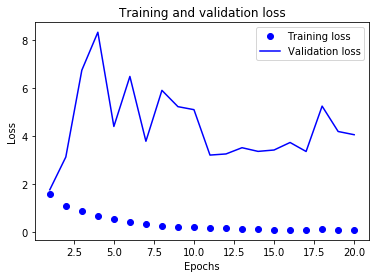

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

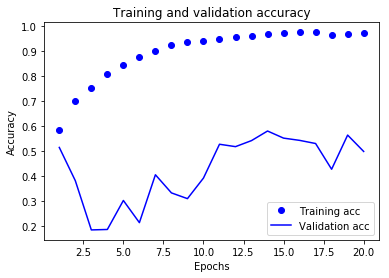

In [120]:
plt.clf()   # clear figure
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(len(df_train.NTEE1.unique()))
    layer = Activation('softmax')
    model = Model(inputs=inputs,outputs=layer)
    return model

In [32]:
num_labels=len(train_df['label'].drop_duplicates())
batch_size = 2000
epochs = 40

model = keras.Sequential()
model.add(keras.layers.Dense(512, input_shape=(vocab_size,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(num_labels))
model.add(keras.layers.Activation('softmax'))
model.add(keras.layers.LSTM(100))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
             )

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=0.2)

NameError: name 'train_df' is not defined

In [17]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [31]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

ValueError: Output tensors to a Model must be the output of a Keras `Layer` (thus holding past layer metadata). Found: <keras.layers.core.Activation object at 0x000001D077CB0E48>

In [19]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 156040 samples, validate on 39011 samples
Epoch 1/20
156040/156040 [==============================] - 667s 4ms/step - loss: -137.7159 - acc: 0.1669 - val_loss: -138.5898 - val_acc: 0.1687
Epoch 2/20
156040/156040 [==============================] - 657s 4ms/step - loss: -138.5325 - acc: 0.1669 - val_loss: -138.5898 - val_acc: 0.1687


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [4]:
txt_field='mission_prgrm'
small_num=0
while small_num<100: # Make sure each category has at least 100 records.
    trainDF = df_train[df_train.mission.notna() & df_train.NTEE1.notna()].sample(100000)
    small_num=trainDF.groupby('NTEE1').count().sort_values('EIN').iloc[0]['EIN']
#### Sample ####
trainDF['text'] = trainDF[txt_field].astype(str)
trainDF['label'] = trainDF['NTEE1'].astype(str)

In [5]:
print("Total len: ", len(trainDF))
print(trainDF['label'].unique())

#test_df = pd.DataFrame(trainDF['label'].unique())
#test_df.to_csv("../../data/classification_results/results_nteecc/list_of_classes.csv")

#total classes: 1327

Total len:  100000
['N' 'W' 'B' 'P' 'S' 'E' 'I' 'L' 'A' 'Y' 'K' 'M' 'X' 'G' 'C' 'T' 'H' 'R'
 'O' 'J' 'Q' 'D' 'F' 'U' 'V']


In [31]:
import statistics

counts = trainDF['label'].value_counts().sort_index().to_frame()
counts['category'] = counts.index
counts['train_sample']=(counts['label']/2).astype(int)
    
train_df, test_df = np.split(trainDF, [int(.7*len(trainDF))])

#tf.logging.set_verbosity(tf.logging.ERROR)

train_posts = train_df['text']
train_tags = train_df['label']
test_posts = test_df['text']
test_tags = test_df['label']
vocab_size = 10000
#precision & recall by: Other text preprocessing: https://keras.io/preprocessing/text/ 
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(train_posts)

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = preprocessing.LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)
    
num_labels=len(train_df['label'].drop_duplicates())
batch_size = 2000
epochs = 40

model = keras.Sequential()
model.add(keras.layers.Dense(512, input_shape=(vocab_size,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(num_labels))
model.add(keras.layers.Activation('softmax'))
model.add(keras.layers.LSTM(100))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
             )

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=0.2)

ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 25]

In [22]:
score = model.evaluate(x_test, y_test, 
                       batch_size=batch_size, verbose=1)

30000/30000 [==============================] - 3s 116us/step


In [23]:
print(score)

[2.128798747062683, 0.6859999974568685, 0.7078190843264262, 0.6734666744867961]


In [24]:
results = model.evaluate(x_test, y_test)
print(results)

30000/30000 [==============================] - 4s 138us/step
[2.128798867638906, 0.686, 0.7077912830034891, 0.6734666666666667]


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])

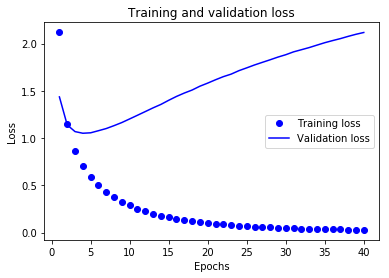

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

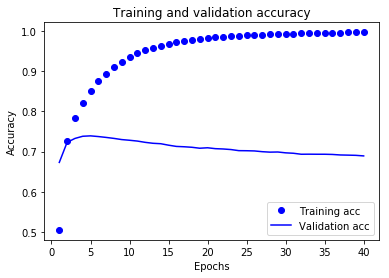

In [27]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [4]:
#acc till 85: increases by 2% every epoch
#acc 85 - 95: increases by 1% each epoch
# 95 - 96: 4 epochs
# 96 - 97: >18 epochs

from tqdm import tqdm_notebook as tqdm
    
all_pred = pd.DataFrame(columns=['EIN', 'text', 'actual_label', 'predicted_label', 'true_pred'])


for i in tqdm(range(len(x_test))):
    prediction = model.predict(np.array([x_test[i]]))    
    text_labels = encoder.classes_ 
    predicted_label = text_labels[np.argmax(prediction[0])]
    text = test_posts.iloc[i]
    ein = trainDF[trainDF['text']==test_posts.iloc[i]]['EIN'].astype(int).drop_duplicates().tolist()
    actual_label = trainDF[trainDF['text']==test_posts.iloc[i]]['label'].drop_duplicates().tolist()
    if(predicted_label == test_tags.iloc[i]):
        true_pred = 'true'
    else:
        true_pred = 'false'

    all_pred.loc[len(all_pred)] = [ein, text, actual_label, predicted_label, true_pred]


if(os.path.exists('../../data/classification_results/all_predictions_V3.pkl.gz')):
    all_pred = pd.concat([pd.read_pickle('../../data/classification_results/all_predictions_V3.pkl.gz'), all_pred]).drop_duplicates()
    
all_pred.to_pickle('../../data/classification_results/all_predictions_V3.pkl.gz')
